
# Sentiment_analysis using sentiment140-dataset. NLP application
In this project I am using a variation of the [Sentiment140 dataset](http://help.sentiment140.com/home), which contains 1.6 million tweets alongside their respective sentiment (0 for negative and 4 for positive).


In [ ]:
# Import required libs. install them first if required

import csv
import random
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from scipy.stats import linregress

## Defining  useful global variables

The following global variables  will be used throughout the assignment.

- `EMBEDDING_DIM`: Dimension of the dense embedding, will be used in the embedding layer of the model. Defaults to 100.


- `MAXLEN`: Maximum length of all sequences. Defaults to 16.


- `TRUNCATING`: Truncating strategy (truncate either before or after each sequence.). Defaults to 'post'.


- `PADDING`: Padding strategy (pad either before or after each sequence.). Defaults to 'post'.


- `OOV_TOKEN`: Token to replace out-of-vocabulary words during text_to_sequence calls. Defaults to \"\<OOV>\".
    
    
- `MAX_EXAMPLES`: Max number of examples to use. Defaults to 160000 (10% of the original number of examples)
    
    
- `TRAINING_SPLIT`: Proportion of data used for training. Defaults to 0.9
    
    

In [ ]:
# grader-required-cell

EMBEDDING_DIM = 100
MAXLEN = 16
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = "<OOV>"
MAX_EXAMPLES = 160000
TRAINING_SPLIT = 0.9

## Explore the dataset

The dataset is provided in a csv file.

Each row of this file contains the following values separated by commas:

- target: the polarity of the tweet (0 = negative, 4 = positive)

- ids: The id of the tweet

- date: the date of the tweet

- flag: The query. If there is no query, then this value is NO_QUERY.

- user: the user that tweeted

- text: the text of the tweet




In [ ]:

SENTIMENT_CSV = "./data/training_cleaned.csv"

with open(SENTIMENT_CSV, 'r') as csvfile:
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

First data point looks like this:

"0","1467810369","Mon Apr 06 22:19:45 PDT 2009","NO_QUERY","_TheSpecialOne_","@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

Second data point looks like this:

"0","1467810672","Mon Apr 06 22:19:49 PDT 2009","NO_QUERY","scotthamilton","is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"



## Parsing the raw data



In [ ]:
# FUNCTION: parse_data_from_file
def parse_data_from_file(filename):
    """
    Extracts sentences and labels from a CSV file

    Args:
        filename (string): path to the CSV file

    Returns:
        sentences, labels (list of string, list of string): tuple containing lists of sentences and labels
    """

    sentences = []
    labels = []

    with open(filename, 'r') as csvfile:
        ### START CODE HERE
        reader = csv.reader(csvfile, delimiter=",")

        for line in reader:
            sentences.append(line[5])
            labels.append(line[0])
        ### END CODE HERE
        for i in range(len(labels)):
            if labels[i]=="4":
                labels[i]=1
            else:
                labels[i]=0

    return sentences, labels

In [ ]:


# Testing function
sentences, labels = parse_data_from_file(SENTIMENT_CSV)

print(f"dataset contains {len(sentences)} examples\n")

print(f"Text of second example should look like this:\n{sentences[1]}\n")
print(f"Text of fourth example should look like this:\n{sentences[3]}")

print(f"\nLabels of last 5 examples should look like this:\n{labels[-5:]}")

dataset contains 1600000 examples

Text of second example should look like this:
is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!

Text of fourth example should look like this:
my whole body feels itchy and like its on fire 

Labels of last 5 examples should look like this:
[1, 1, 1, 1, 1]


 In order to keep a low execution time of this assignment I am using only 10% of the original data. The next cell does this while also randomnizing the datapoints that will be used:

In [ ]:

# Bundle the two lists into a single one
sentences_and_labels = list(zip(sentences, labels))

# Perform random sampling
random.seed(42)
sentences_and_labels = random.sample(sentences_and_labels, MAX_EXAMPLES)

# Unpack back into separate lists
sentences, labels = zip(*sentences_and_labels)

print(f"There are {len(sentences)} sentences and {len(labels)} labels after random sampling\n")

There are 160000 sentences and 160000 labels after random sampling



## Training - Validation Split

The next is to  code  `train_val_split` function , which given the list of sentences, the list of labels and the proportion of data for the training set, should return the training and validation sentences and labels:

In [ ]:


#  train_val_split
def train_val_split(sentences, labels, training_split):
    """
    Splits the dataset into training and validation sets

    Args:
        sentences (list of string): lower-cased sentences without stopwords
        labels (list of string): list of labels
        training split (float): proportion of the dataset to convert to include in the train set

    Returns:
        train_sentences, validation_sentences, train_labels, validation_labels - lists containing the data splits
    """
    ### START CODE HERE

    # Compute the number of sentences that will be used for training (should be an integer)
    train_size = int(training_split*len(sentences))

    # Split the sentences and labels into train/validation splits
    train_sentences = sentences[0:train_size]
    train_labels =  labels[0:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]

    ### END CODE HERE

    return train_sentences, validation_sentences, train_labels, validation_labels

In [ ]:


# Test function
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 144000 sentences for training.

There are 144000 labels for training.

There are 16000 sentences for validation.

There are 16000 labels for validation.


***Expected Output:***

```
There are 144000 sentences for training.

There are 144000 labels for training.

There are 16000 sentences for validation.

There are 16000 labels for validation.

```

## Tokenization - Sequences, truncating and padding


In [ ]:
# fit_tokenizer
def fit_tokenizer(train_sentences, oov_token):
    """
    Instantiates the Tokenizer class on the training sentences

    Args:
        train_sentences (list of string): lower-cased sentences without stopwords to be used for training
        oov_token (string) - symbol for the out-of-vocabulary token

    Returns:
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    """
    ### START CODE HERE

    # Instantiate the Tokenizer class, passing in the correct values for oov_token
    tokenizer = Tokenizer(oov_token=oov_token)
    tokenizer.fit_on_texts(train_sentences)
    #sequences=tokenizer.texts_to_sequences(train_sentences)

    # Fit the tokenizer to the training sentences


    ### END CODE HERE

    return tokenizer

In [ ]:


# Test  function
tokenizer = fit_tokenizer(train_sentences, OOV_TOKEN)

word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)

print(f"Vocabulary contains {VOCAB_SIZE} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")
print(f"\nindex of word 'i' should be {word_index['i']}")

Vocabulary contains 128293 words

<OOV> token included in vocabulary

index of word 'i' should be 2


***Expected Output:***

```
Vocabulary contains 128293 words

<OOV> token included in vocabulary

index of word 'i' should be 2

```

In [ ]:
#  seq_pad_and_trunc
def seq_pad_and_trunc(sentences, tokenizer, padding, truncating, maxlen):
    """
    Generates an array of token sequences and pads them to the same length

    Args:
        sentences (list of string): list of sentences to tokenize and pad
        tokenizer (object): Tokenizer instance containing the word-index dictionary
        padding (string): type of padding to use
        truncating (string): type of truncating to use
        maxlen (int): maximum length of the token sequence

    Returns:
        pad_trunc_sequences (array of int): tokenized sentences padded to the same length
    """
    ### START CODE HERE

    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)

    # Pad the sequences using the correct padding, truncating and maxlen
    pad_trunc_sequences = pad_sequences(sequences,padding=padding,truncating=truncating,maxlen=maxlen)

    ### END CODE HERE

    return pad_trunc_sequences

In [ ]:
#Test  function
train_pad_trunc_seq = seq_pad_and_trunc(train_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)
val_pad_trunc_seq = seq_pad_and_trunc(val_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)

print(f"Padded and truncated training sequences have shape: {train_pad_trunc_seq.shape}\n")
print(f"Padded and truncated validation sequences have shape: {val_pad_trunc_seq.shape}")

Padded and truncated training sequences have shape: (144000, 16)

Padded and truncated validation sequences have shape: (16000, 16)


In [ ]:


train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

# Using pre-defined Embeddings

 the 100 dimension version of [GloVe](https://nlp.stanford.edu/projects/glove/) from Stanford.

In [ ]:


# Define path to file containing the embeddings
GLOVE_FILE = './data/glove.6B.100d.txt'

# Initialize an empty embeddings index dictionary
GLOVE_EMBEDDINGS = {}

# Read file and fill GLOVE_EMBEDDINGS with its contents
with open(GLOVE_FILE) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs

## Represent the words in your vocabulary using the embeddings



In [ ]:


# Initialize an empty numpy array with the appropriate size
EMBEDDINGS_MATRIX = np.zeros((VOCAB_SIZE+1, EMBEDDING_DIM))

# Iterate all of the words in the vocabulary and if the vector representation for
# each word exists within GloVe's representations, save it in the EMBEDDINGS_MATRIX array
for word, i in word_index.items():
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector

## Define a model

In [ ]:
#  create_model
def create_model(vocab_size, embedding_dim, maxlen, embeddings_matrix):
    """
    Creates a binary sentiment classifier model

    Args:
        vocab_size (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences
        embeddings_matrix (array): predefined weights of the embeddings

    Returns:
        model (tf.keras Model): the sentiment classifier model
    """
    ### START CODE HERE

    model = tf.keras.Sequential([
        # This is how you need to set the Embedding layer when using pre-trained embeddings
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=maxlen, weights=[embeddings_matrix], trainable=False),
        tf.keras.layers.Dropout(0.2),
#         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Conv1D(32, 5, activation='relu'),
        tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')])

    model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

    ### END CODE HERE

    return model

In [ ]:


# Create  untrained model
model = create_model(VOCAB_SIZE, EMBEDDING_DIM, MAXLEN, EMBEDDINGS_MATRIX)

# Train the model and save the training history
history = model.fit(train_pad_trunc_seq, train_labels, epochs=20, validation_data=(val_pad_trunc_seq, val_labels))

Epoch 1/20
4500/4500 [==============================] - 182s 40ms/step - loss: 0.5379 - accuracy: 0.7252 - val_loss: 0.4949 - val_accuracy: 0.7554
Epoch 2/20
4500/4500 [==============================] - 179s 40ms/step - loss: 0.4840 - accuracy: 0.7648 - val_loss: 0.4743 - val_accuracy: 0.7720
Epoch 3/20
4500/4500 [==============================] - 174s 39ms/step - loss: 0.4590 - accuracy: 0.7813 - val_loss: 0.4674 - val_accuracy: 0.7761
Epoch 4/20
4500/4500 [==============================] - 173s 38ms/step - loss: 0.4381 - accuracy: 0.7951 - val_loss: 0.4628 - val_accuracy: 0.7804
Epoch 5/20
4500/4500 [==============================] - 176s 39ms/step - loss: 0.4185 - accuracy: 0.8053 - val_loss: 0.4652 - val_accuracy: 0.7810
Epoch 6/20
4500/4500 [==============================] - 172s 38ms/step - loss: 0.3986 - accuracy: 0.8180 - val_loss: 0.4730 - val_accuracy: 0.7834
Epoch 7/20
4500/4500 [==============================] - 173s 38ms/step - loss: 0.3786 - accuracy: 0.8286 - val_loss: 0

In [ ]:
val_labels.shape

(16000,)

### checking  the training and validation accuracies of your model:

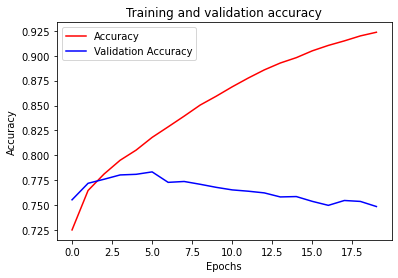

In [ ]:


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()